<a href="https://colab.research.google.com/github/Phoebe83/ANLY-590/blob/master/590_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 3
Yue Han

###1. Autoencoder
Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we’ve used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.

In [0]:
from keras.datasets import fashion_mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Conv1D, MaxPooling1D, Embedding, LSTM
from keras.utils import np_utils
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications import VGG16, ResNet50
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk

#!pip install tweet-preprocessor
import preprocessor as p
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
#Load Fashion MINIST data and split to training and test sets.
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

Shape of training set:  (60000, 28, 28)
Shape of test set: (10000, 28, 28)


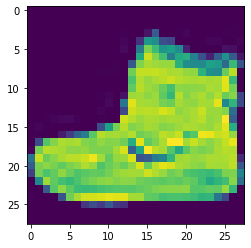

In [4]:
#Check dataset
print("Shape of training set: ", X_train.shape)
print("Shape of test set:", X_test.shape)
plt.imshow(X_train[0])

In [23]:
# Setting up values as float32s and reshape the 28x28 images
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))  
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
input_img = Input(shape=(28, 28, 1))

# construct encoder of the network
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [0]:
# construct decoder of the network
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [20]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0   

In [24]:
# fit the autoencoder with training dataset
autoencoder.fit(X_train, X_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_split=0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 7s 168us/step - loss: 0.3913 - val_loss: 0.3411
Epoch 2/5
42000/42000 [==============================] - 5s 124us/step - loss: 0.3298 - val_loss: 0.3200
Epoch 3/5
42000/42000 [==============================] - 5s 127us/step - loss: 0.3184 - val_loss: 0.3180
Epoch 4/5
42000/42000 [==============================] - 6s 132us/step - loss: 0.3119 - val_loss: 0.3053
Epoch 5/5
42000/42000 [==============================] - 6s 131us/step - loss: 0.3077 - val_loss: 0.3075


In [0]:
decoded_imgs = autoencoder.predict(X_test)

<Figure size 432x288 with 0 Axes>

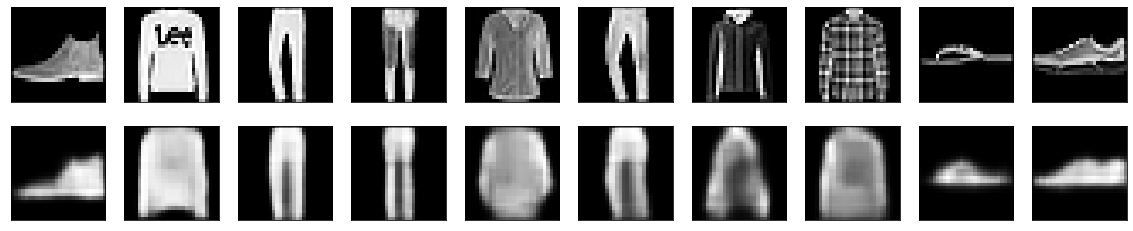

In [26]:
#Display original and reconstructed image
plt.clf()
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### 2. Image Classification
2.1 Deep CNN<br>
Build a deep CNN to classify the images. Provide a brief description of the architectural choices you’ve made: kernel sizes, strides, padding, network depth. Train your network end-to-end. Report on your model’s performance on training set and test set.


In [27]:
# Build up the CNN Architechture with Sequential layer
model = Sequential()

# Add up the input layers
# Add the 1st convolutional layer
model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28,28,1)))
print(model.output_shape)

(None, 26, 26, 32)


In [0]:
# Add the 2st convolutional layer
model.add(Conv2D(filters = 64,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid', 
                 input_shape=(28,28,1)))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [29]:
# Set up the dense layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

# Check out the model structure 
print(model.summary()) 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                589888    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

I use two convolution layers In my CNN Architecture. They both have 6 by 6 kernal size, 1 by 1 stride, relu activation function, and no padding. The second convolution layer followed with a MaxPooling layer and a drop out. Then I added two dense layer with 56 and 10 neurons respectively, with a dropout layer in between. For the activation function, besides the softmax in the last layer, I applied relu activation to all other layers. 

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [119]:
#Complile and fit the Model 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=5,  # use 5 epochs
          batch_size=128,
          validation_split= 0.3) # use 0.3 of the training dataset as validation set

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 106s 3ms/step - loss: 0.5154 - acc: 0.8171 - val_loss: 0.3546 - val_acc: 0.8730
Epoch 2/5
42000/42000 [==============================] - 104s 2ms/step - loss: 0.3581 - acc: 0.8734 - val_loss: 0.3063 - val_acc: 0.8898
Epoch 3/5
42000/42000 [==============================] - 104s 2ms/step - loss: 0.3026 - acc: 0.8910 - val_loss: 0.2746 - val_acc: 0.9020
Epoch 4/5
42000/42000 [==============================] - 104s 2ms/step - loss: 0.2703 - acc: 0.9030 - val_loss: 0.2551 - val_acc: 0.9074
Epoch 5/5
42000/42000 [==============================] - 104s 2ms/step - loss: 0.2444 - acc: 0.9095 - val_loss: 0.2446 - val_acc: 0.9118


In [120]:
# evaluate the model on the test set 
test_score = model.evaluate(X_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

10000/10000 [==============================] - 6s 613us/step
Test loss: 0.25906288145780565
Test accuracy: 0.9071


The model on the training set has an accuracy of 0.91 and a loss of 0.24. On the test set it has an accuracy of 0.91 and a loss of 0.26.




2.2 Transfer Learning <br>
Repeat the same task, but this time utilize a pre-trained network for the majority of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet, VGG, etc). Report on your model’s performance on training set and test set.

In [0]:
# Use the VGG pre-trained backbone
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(48,48,3))

In [32]:
# Add up the dense layers
model2 = Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation="softmax"))

# Check out model structure
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [0]:
conv_base.trainable = False

In [38]:
# Reshape the dataset to fit the model
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

X_train = np.dstack([X_train] * 3)
X_test = np.dstack([X_test] * 3)

X_train = X_train.reshape(-1, 28, 28, 3)
X_test = X_test.reshape (-1, 28, 28, 3)

X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_train])/255.
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_test])/255.

print(X_train.shape)
print(X_test.shape)

(60000, 48, 48, 3)
(10000, 48, 48, 3)


In [39]:
# complie and fit the model
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train, y_train,
          epochs=5,
          batch_size=128,
          validation_split= 0.3)

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 34s 821us/step - loss: 0.7596 - acc: 0.7286 - val_loss: 0.5342 - val_acc: 0.8071
Epoch 2/5
42000/42000 [==============================] - 34s 798us/step - loss: 0.5187 - acc: 0.8136 - val_loss: 0.4684 - val_acc: 0.8294
Epoch 3/5
42000/42000 [==============================] - 34s 800us/step - loss: 0.4757 - acc: 0.8286 - val_loss: 0.4398 - val_acc: 0.8378
Epoch 4/5
42000/42000 [==============================] - 34s 802us/step - loss: 0.4490 - acc: 0.8362 - val_loss: 0.4440 - val_acc: 0.8381
Epoch 5/5
42000/42000 [==============================] - 34s 804us/step - loss: 0.4265 - acc: 0.8457 - val_loss: 0.4389 - val_acc: 0.8407


In [40]:
#Evaluate the model on the test set
test_score = model2.evaluate(X_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

10000/10000 [==============================] - 9s 861us/step
Test loss: 0.46311080114841463
Test accuracy: 0.8383


The model on the training set has an accuracy of 0.85 and a loss of 0.43. On the test set it has an accuracy of 0.83 and a loss of 0.46.

### 3. Text Classification 
3.1 RNN <br>
Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).


In [48]:
from google.colab import files
uploaded = files.upload()

Saving tweets_with_labels.csv to tweets_with_labels.csv


In [0]:
# Load dataset
tweets = pd.read_csv("tweets_with_labels.csv", sep='\t',error_bad_lines=False)

In [63]:
# Check out dataset
tweets.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [61]:
tweets.shape

(77946, 17)

In [67]:
# customize the clean method
#remove URL, metion tag, hash tag, and emoji 
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.EMOJI)

for i in range(0, 77946):
  #tokenize tweet
  tweets.tweet[i] = p.tokenize(tweets.tweet[i])
  #conduct cleaning
  tweets.tweet[i] = p.clean(tweets.tweet[i])

  #fill the space cleaned to be empty
  if tweets.tweet[i] == []:
    tweets.tweet[i] = 'no words left'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [71]:
# Check out the cleaned data
tweets.tweet.head()

0                   Jazz for a Rainy Afternoon: {link}
1                               : : I love rainy days.
2    Good Morning Chicago! Time to kick the Windy C...
3    Preach lol! RT : this type of weather all the ...
4                                good morning sunshine
Name: tweet, dtype: object

In [0]:
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(tweets.tweet)
sequences = tokenizer.texts_to_sequences(tweets.tweet)
x = pad_sequences(sequences, maxlen=180)

In [86]:
tweets.iloc[:,1]

0                       Jazz for a Rainy Afternoon: {link}
1                                   : : I love rainy days.
2        Good Morning Chicago! Time to kick the Windy C...
3        Preach lol! RT : this type of weather all the ...
4                                    good morning sunshine
                               ...                        
77941    Current Conditions: Fair, FForecast: Sat - Sun...
77942    WE DOIN SOMETHING DIFFERENT... SINCE THE WEATH...
77943              OMG for tomm degrees & Sunny &lt;=== yo
77944    Oh no! We had cold weather early in the week, ...
77945    North Cascades Hwy to reopen Wed.: quite late ...
Name: tweet, Length: 77946, dtype: object

In [0]:
#get the y label
 y = tweets.iloc[:, 2:17]

In [0]:
#split the train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

MAX_NUM_WORDS = 500 
MAX_SEQUENCE_LENGTH = 50 

In [108]:
#Build the model
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH))
model.add(LSTM(32))
model.add(Dense(15, activation ='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          25000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_14 (Dense)             (None, 15)                495       
Total params: 36,119
Trainable params: 36,119
Non-trainable params: 0
_________________________________________________________________


In [111]:
# Compile and fit the model
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train, 
                    epochs = 5, batch_size = 64, 
                    validation_split = 0.3,
                    verbose=1)

Train on 43649 samples, validate on 18707 samples
Epoch 1/5
43649/43649 [==============================] - 227s 5ms/step - loss: 0.2000 - acc: 0.8801 - val_loss: 0.1776 - val_acc: 0.8847
Epoch 2/5
43649/43649 [==============================] - 226s 5ms/step - loss: 0.1406 - acc: 0.9021 - val_loss: 0.1254 - val_acc: 0.9057
Epoch 3/5
43649/43649 [==============================] - 229s 5ms/step - loss: 0.1192 - acc: 0.9089 - val_loss: 0.1223 - val_acc: 0.9063
Epoch 4/5
43649/43649 [==============================] - 223s 5ms/step - loss: 0.1131 - acc: 0.9104 - val_loss: 0.1124 - val_acc: 0.9102
Epoch 5/5
43649/43649 [==============================] - 224s 5ms/step - loss: 0.1105 - acc: 0.9109 - val_loss: 0.1110 - val_acc: 0.9106


In [112]:
#Evaluate the model on the test set
test_score = model.evaluate(x_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

15590/15590 [==============================] - 29s 2ms/step
Test loss: 0.11241870308014122
Test accuracy: 0.9099080606023802


3.2 CNN <br>
Build and train a 1D CNN for this text classification task. We recommend you do a character-level convolution (with character embeddings). 

In [0]:
# Build the model with 1D CNN
model_cnn = Sequential()
model_cnn.add(Embedding(10000, input_length = 180, output_dim = 32))
model_cnn.add(Conv1D(32, 3,activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Conv1D(64, 5, activation='relu'))
model_cnn.add(Flatten())    
model_cnn.add(Dense(15, activation ='sigmoid'))


In [136]:
#compile and fit the model
model_cnn.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics=['acc'])

history_cnn = model_cnn.fit(x_train, y_train, 
                    epochs = 5, batch_size = 64, 
                    validation_split = 0.3,
                    verbose=1)

Train on 43649 samples, validate on 18707 samples
Epoch 1/5
43649/43649 [==============================] - 10s 232us/step - loss: 0.1031 - acc: 0.9122 - val_loss: 0.0971 - val_acc: 0.9132
Epoch 2/5
43649/43649 [==============================] - 7s 169us/step - loss: 0.1009 - acc: 0.9127 - val_loss: 0.0991 - val_acc: 0.9132
Epoch 3/5
43649/43649 [==============================] - 8s 179us/step - loss: 0.0994 - acc: 0.9128 - val_loss: 0.0987 - val_acc: 0.9129
Epoch 4/5
43649/43649 [==============================] - 8s 178us/step - loss: 0.0979 - acc: 0.9133 - val_loss: 0.0999 - val_acc: 0.9128
Epoch 5/5
43649/43649 [==============================] - 8s 182us/step - loss: 0.0967 - acc: 0.9136 - val_loss: 0.1006 - val_acc: 0.9127


In [137]:
#Evaluate the model on the test set
test_score = model_cnn.evaluate(x_test, y_test)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

15590/15590 [==============================] - 1s 82us/step
Test loss: 0.1074712442216237
Test accuracy: 0.9104810786828389


3.3 Be sure to directly compare your two methods with an ROC curve or similar validation method. Don’t forget to create a train-test split. <br>

From 3.1 and 3.2 above, we have the following results for the RNN and CNN model:<br>
* RNN: train accuracy = 0.9109, test accuracy = 0.9099
* CNN: train accuracy = 0.9117, test accuracy = 0.9111

In [0]:
y_pred_rnn = model.predict(x_test)
y_pred_cnn = model_cnn.predict(x_test)

In [0]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(15):
    pred = [j == max(y_test.iloc[i]) for j in y_test.iloc[i]]
    fpr[i], tpr[i], _ = roc_curve(pred, np.array(y_pred_rnn[i]))
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()
for i in range(15):
    pred = [j == max(y_test.iloc[i]) for j in y_test.iloc[i]]
    fpr1[i], tpr1[i], _ = roc_curve(pred, np.array(y_pred_cnn[i]))
    roc_auc1[i] = auc(fpr1[i], tpr1[i])

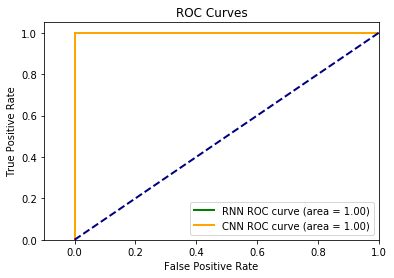

In [142]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='green',
         lw=lw, label='RNN ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr1[2], tpr1[2], color='orange',
         lw=lw, label='CNN ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

From the ROC curve above, we can see that both RNN and CNN performs very well, although from the accuracy results, we can notice that CNN performs slightly better. 